# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 91439498.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35659609.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27194086.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14216812.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**The transforms `ToTensor()` and `Normalize()` were chosen for the MNIST dataset to convert the images into tensors and normalize the pixel values. This helps ensure that the data is in a suitable format for training deep learning models and improves model performance and convergence.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
Label: 8


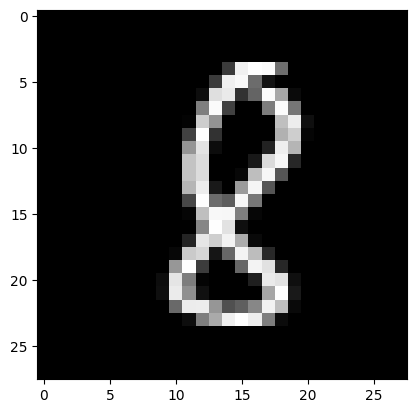

Label: 2


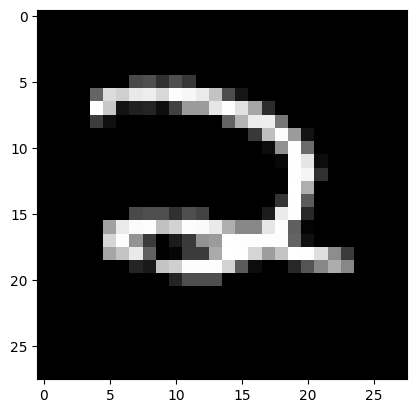

Label: 1


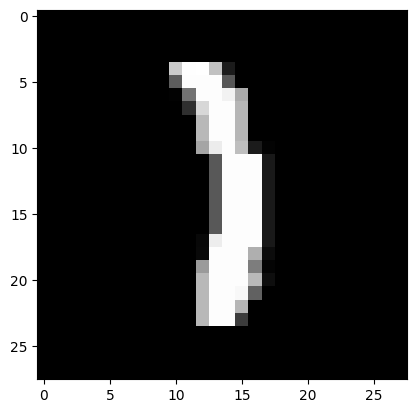

Label: 0


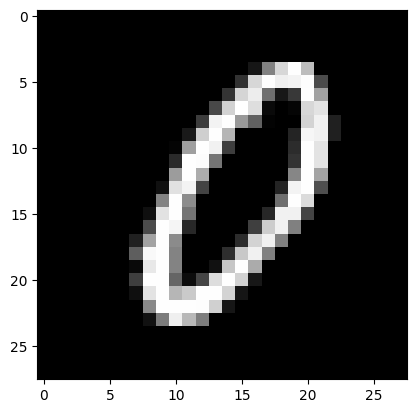

Label: 6


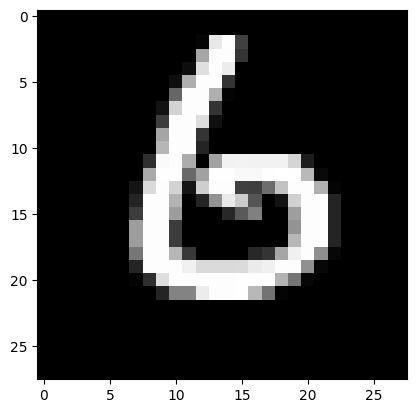

In [6]:
# Explore data
# Get a batch of images from the training set
images, labels = next(iter(trainloader))

# Display the dimensions of the data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Visualize a few images
def show5(img_loader):
    images, labels = next(iter(img_loader))
    for i in range(5):
        print("Label:", int(labels[i].item()))
        image = images[i].numpy()
        plt.imshow(image.squeeze(), cmap='gray')
        plt.show()

# Show 5 images from the training set
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
# Instantiate the model
model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
# Specify the loss function
loss_fn = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

num_epochs = 10
train_loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 250 == 249:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss/250:.3f}")
            train_loss_values.append(running_loss / 250)
            running_loss = 0.0

[Epoch 1, Batch 250] Loss: 2.024
[Epoch 1, Batch 500] Loss: 1.022
[Epoch 1, Batch 750] Loss: 0.606
[Epoch 2, Batch 250] Loss: 0.427
[Epoch 2, Batch 500] Loss: 0.375
[Epoch 2, Batch 750] Loss: 0.369
[Epoch 3, Batch 250] Loss: 0.334
[Epoch 3, Batch 500] Loss: 0.318
[Epoch 3, Batch 750] Loss: 0.322
[Epoch 4, Batch 250] Loss: 0.298
[Epoch 4, Batch 500] Loss: 0.298
[Epoch 4, Batch 750] Loss: 0.279
[Epoch 5, Batch 250] Loss: 0.266
[Epoch 5, Batch 500] Loss: 0.266
[Epoch 5, Batch 750] Loss: 0.265
[Epoch 6, Batch 250] Loss: 0.254
[Epoch 6, Batch 500] Loss: 0.243
[Epoch 6, Batch 750] Loss: 0.238
[Epoch 7, Batch 250] Loss: 0.228
[Epoch 7, Batch 500] Loss: 0.214
[Epoch 7, Batch 750] Loss: 0.228
[Epoch 8, Batch 250] Loss: 0.208
[Epoch 8, Batch 500] Loss: 0.211
[Epoch 8, Batch 750] Loss: 0.208
[Epoch 9, Batch 250] Loss: 0.186
[Epoch 9, Batch 500] Loss: 0.194
[Epoch 9, Batch 750] Loss: 0.187
[Epoch 10, Batch 250] Loss: 0.182
[Epoch 10, Batch 500] Loss: 0.177
[Epoch 10, Batch 750] Loss: 0.172


Plot the training loss (and validation loss/accuracy, if recorded).

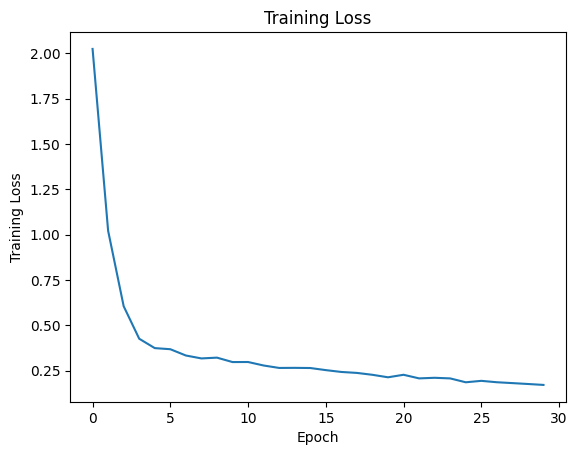

In [10]:
# Plot the training loss
plt.plot(train_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Evaluation mode
model.eval()

# Variables for accuracy calculation
correct_predictions = 0
total_samples = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted labels
        predicted = torch.argmax(outputs, dim=1)

        # Update counts
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Compute accuracy
accuracy = 100 * correct_predictions / total_samples
print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 94.68%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
# Instantiate the model
model = Net()

# Specify the loss function
loss_fn = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with modified hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

num_epochs = 15  # Increased number of epochs
train_loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 250 == 249:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss/250:.3f}")
            train_loss_values.append(running_loss / 250)
            running_loss = 0.0

# Evaluate the model on the test set
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

[Epoch 1, Batch 250] Loss: 0.716
[Epoch 1, Batch 500] Loss: 0.333
[Epoch 1, Batch 750] Loss: 0.295
[Epoch 2, Batch 250] Loss: 0.221
[Epoch 2, Batch 500] Loss: 0.211
[Epoch 2, Batch 750] Loss: 0.194
[Epoch 3, Batch 250] Loss: 0.155
[Epoch 3, Batch 500] Loss: 0.154
[Epoch 3, Batch 750] Loss: 0.144
[Epoch 4, Batch 250] Loss: 0.120
[Epoch 4, Batch 500] Loss: 0.122
[Epoch 4, Batch 750] Loss: 0.119
[Epoch 5, Batch 250] Loss: 0.102
[Epoch 5, Batch 500] Loss: 0.100
[Epoch 5, Batch 750] Loss: 0.101
[Epoch 6, Batch 250] Loss: 0.091
[Epoch 6, Batch 500] Loss: 0.089
[Epoch 6, Batch 750] Loss: 0.087
[Epoch 7, Batch 250] Loss: 0.076
[Epoch 7, Batch 500] Loss: 0.077
[Epoch 7, Batch 750] Loss: 0.081
[Epoch 8, Batch 250] Loss: 0.074
[Epoch 8, Batch 500] Loss: 0.070
[Epoch 8, Batch 750] Loss: 0.075
[Epoch 9, Batch 250] Loss: 0.064
[Epoch 9, Batch 500] Loss: 0.062
[Epoch 9, Batch 750] Loss: 0.066
[Epoch 10, Batch 250] Loss: 0.058
[Epoch 10, Batch 500] Loss: 0.059
[Epoch 10, Batch 750] Loss: 0.055
[Epoch 

In [15]:
accuracy = 100 * correct_predictions / total_samples
print("Accuracy after Hyperparameter Tuning: {:.2f}%".format(accuracy))

Accuracy after Hyperparameter Tuning: 97.26%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Save the trained model
PATH = "model.pth"
torch.save(model.state_dict(), PATH)
